# Part 1: Pre-process the raw dataset and prepare a vector database (ChromaDB) for similarity search

## Step1: Download and prepare the stamp catalog




**1. Download the catalog:**  Visit Mystic Stamp Company's catalog page (https://catalog.mysticstamp.com/) and click the 'Download Pdf file' button to download the free US stamp catalog.  
**2. Upload the Catalog:**  Once downloaded, upload this PDF file (86 MB) to your Colab workspace under '/content'.   
**3. Prepare a small demonstration dataset:**  Extract pages 128 to 130 from the uploaded catalog. These pages contain stamps issued in the year 2012. Save these extracted pages as a new file named "2012.pdf" (1.5 MB).

In [2]:
!pip -q install PyMuPDF # install pymupdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 30.8 MB/s eta 0:00:00


In [3]:
#extract_pages_and_scale_to_letter_size(): extract specific pages from the original pdf and save them to a new pdf file.
#note: ensure pages are scaled to standard letter size. Otherwise, the page width-to-height ratio may shift during the OCR process later.
import fitz
def extract_pages_and_scale_to_letter_size(source_pdf, destination_pdf, start_page_idx, end_page_idx):
    letter_size_width, letter_size_height = (612, 792)
    input_doc = fitz.open(source_pdf)
    output_doc = fitz.open()
    for page_idx in range(start_page_idx, end_page_idx + 1):
        new_page = output_doc.new_page(width=letter_size_width, height=letter_size_height) #create a blank letter-sized page
        new_page.show_pdf_page(new_page.rect, input_doc, page_idx, clip=None, rotate=0, keep_proportion=True, overlay=True) #insert page content
    output_doc.save(destination_pdf)
    input_doc.close()
    output_doc.close()

In [4]:
#extract pages 128-130 and save them to a new pdf file -- 2012.pdf
#note: pdf page indexing starts from 0.
extract_pages_and_scale_to_letter_size("./Mystics_2024_US_Stamp_Catalog.pdf", "./2012.pdf", 127, 129)

In [5]:
!pip -q install pdf2image  #install pdf2image
!sudo apt -qq install -y poppler-utils # install poppler

The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.3_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.3) ...
Setting up poppler-utils (22.02.0-2ubuntu0.3) ...
Processing triggers for man

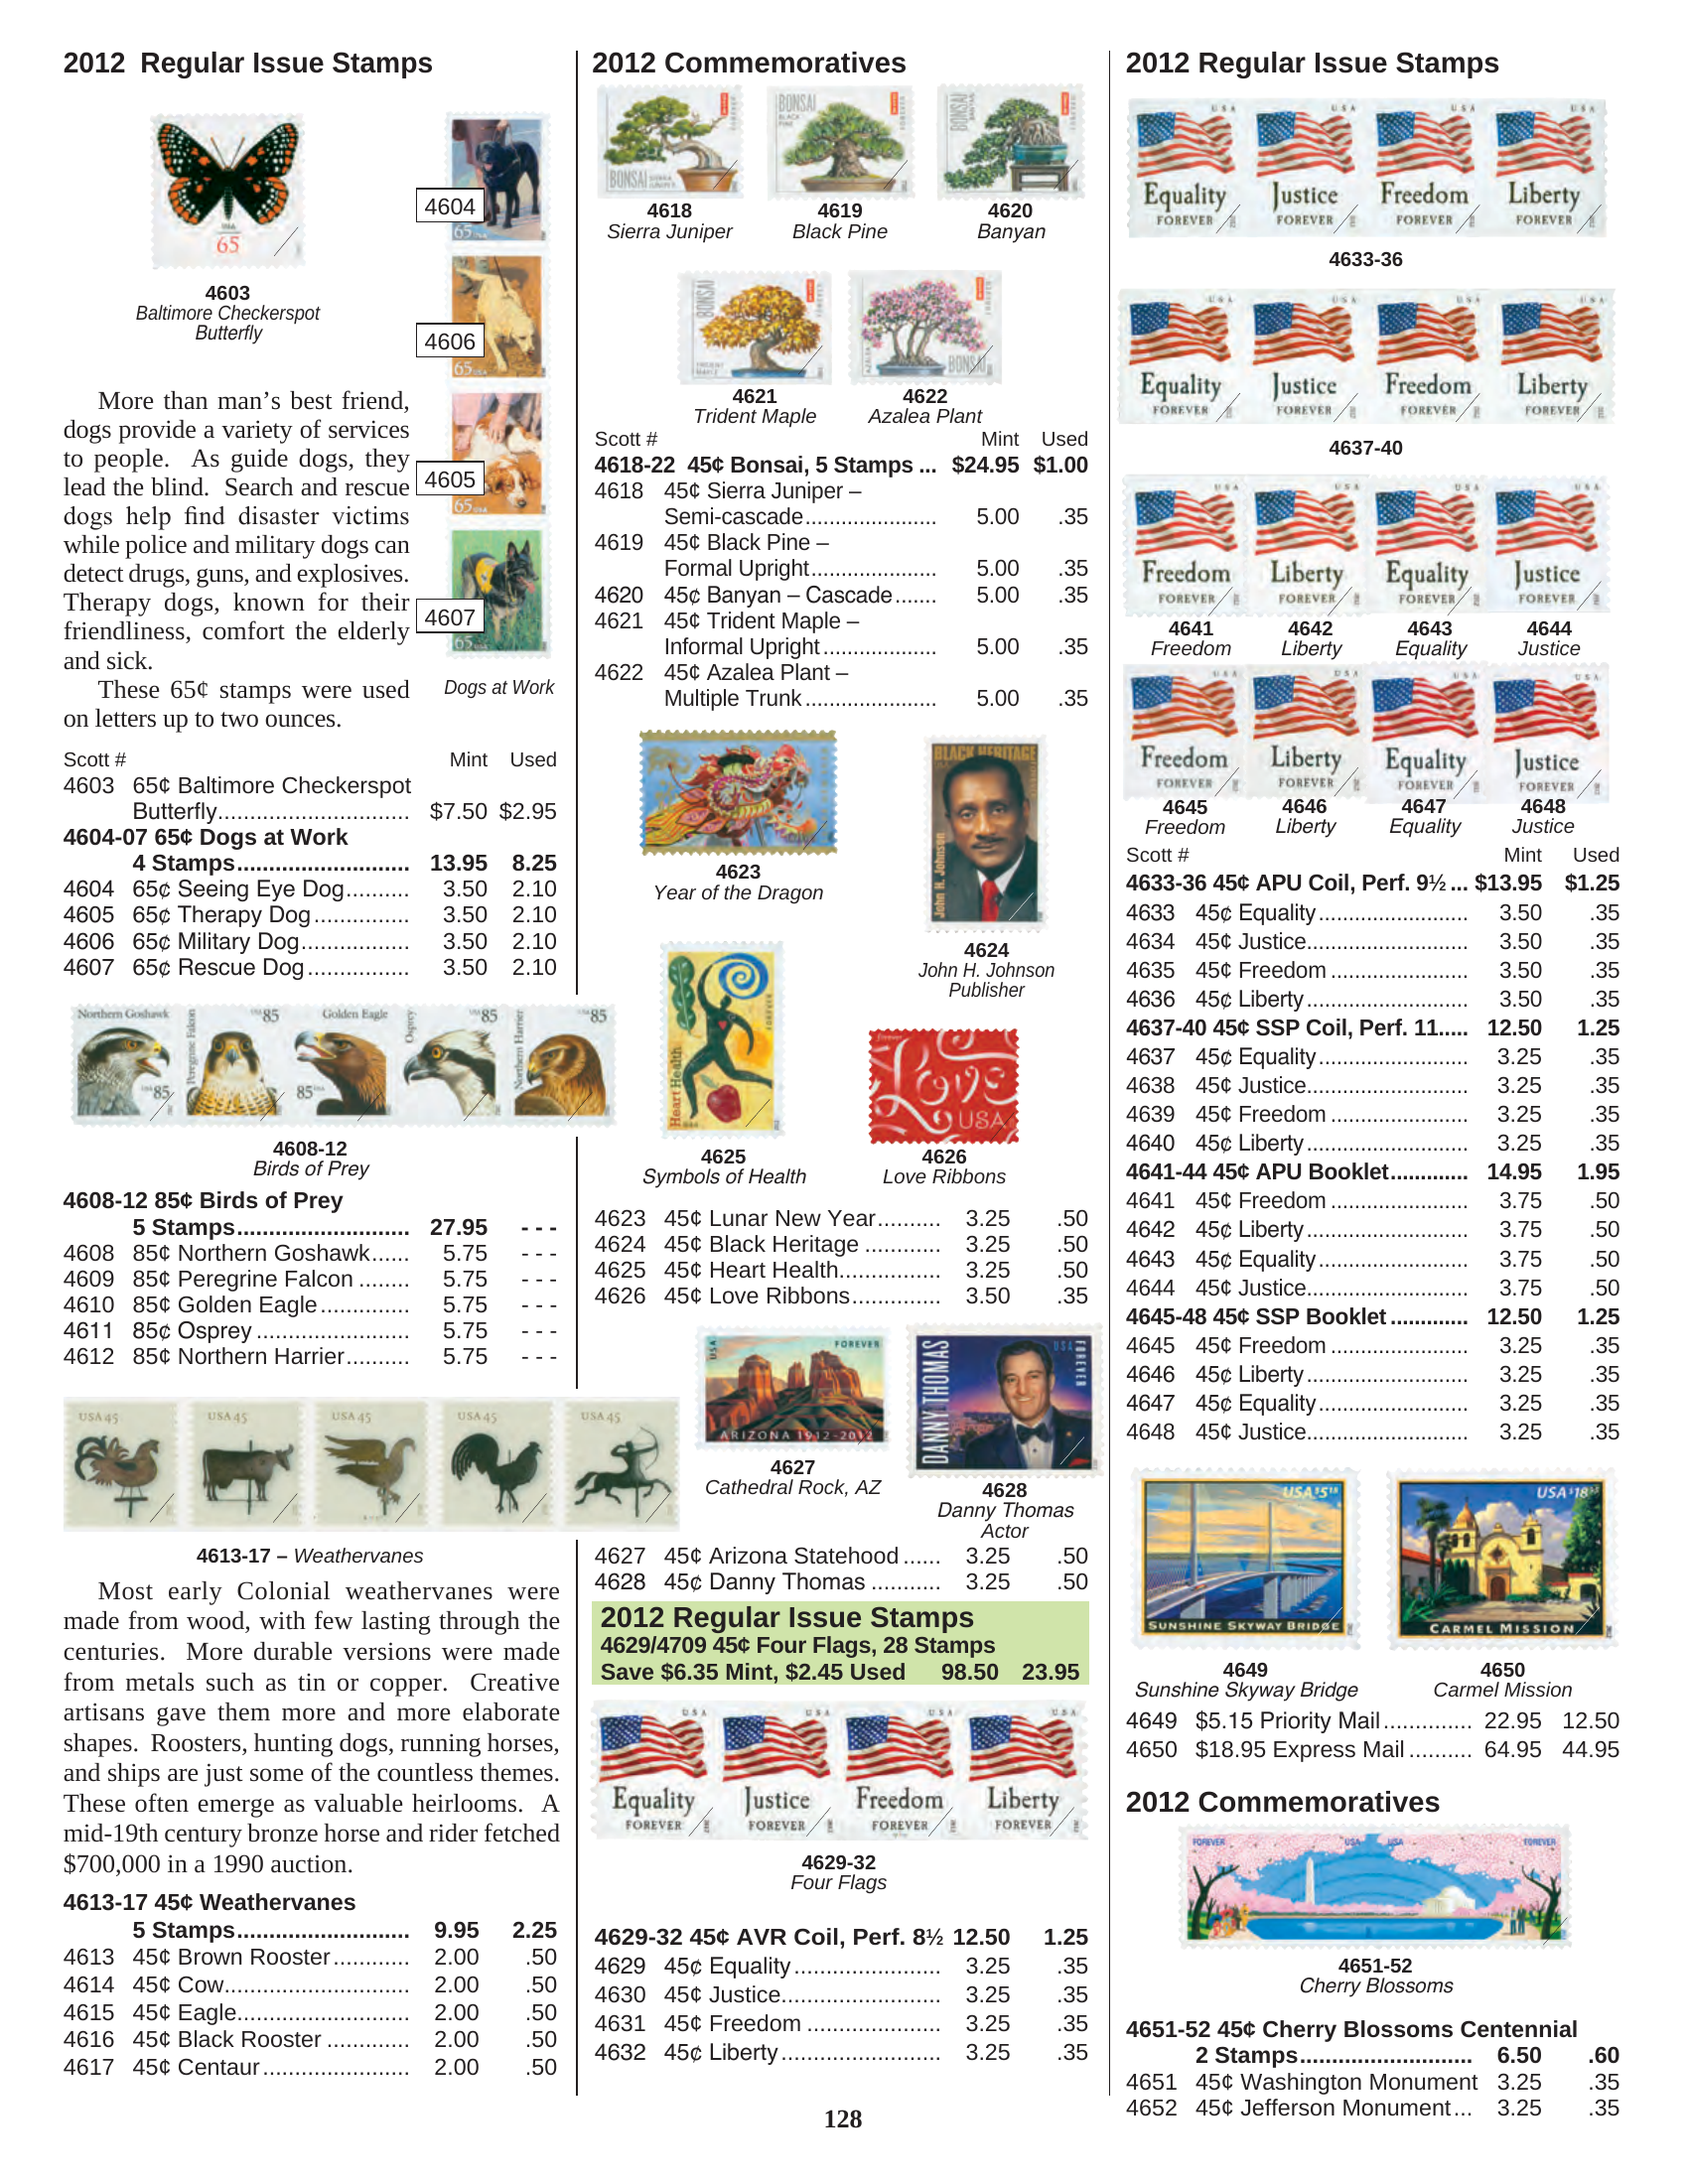

In [6]:
#[Exam] dataset -- "2012.pdf"
import pdf2image
pdf_images = pdf2image.convert_from_path("./2012.pdf")
pdf_images[0]  #display the first page


## Step2: Define utility functions

In [7]:
#print_progress(): print a progress bar
#e.g. [██████████████████████████████--------------------] 60.67%
def print_progress(cur_data, total_data):
    total_bar = 50   #set total bar size to be 50
    cur_percent = (cur_data / total_data) * 100
    cur_bar = int((cur_data / total_data) * total_bar)
    cur_bar_display = '█' * cur_bar + '-' * (total_bar - cur_bar)
    print(f'\r[{cur_bar_display}] {cur_percent:.2f}%', end='\n' if cur_percent == 100 else '') #1)\r: return to linehead 2)end='': not print a new line

#display_stamps(): displays a list of stamps: [(stamp0 tuple), (stamp1 tuple), ...]
#stamp tuple format: (stamp_id, img_file_path, [opt1: similarity_distance], [opt2: scott_number, stamp_name, face_value, mint_value, used_value])
import matplotlib.pyplot as plt
import math
def display_stamps(stamp_list):
    stamp_count = len(stamp_list)
    display_col = 5          #set max 5 stamps per row
    display_row = math.ceil(stamp_count / display_col)
    fig, axes = plt.subplots(display_row, display_col)   #default fig size: 6.4in x 4.8in
    axes = axes.flatten()    #converts axes, whether a single row or multiple rows, into a one-dimensional NumPy array.
    for i, ax in enumerate(axes):
        if (i < stamp_count):
           stamp_id, file_path, *others = stamp_list[i]
           title = stamp_id                     #use stamp_id as the title for each stamp grid
           for item in range(len(others)):
              title += f'\n{others[item][:13]}' #append additional info to the title if available, max 13 characters per item
           cur_img_np = plt.imread(file_path)   #load the image of each grid from 'img_file_path'
           ax.set_title(title, loc='left')
           ax.imshow(cur_img_np)
           ax.axis('off')
        else:                                   #hide axes for empty grids (e.g., displaying 8 stamps in a 2x5 array leaves the last 2 grids empty).
           ax.set_visible(False)
    plt.rcParams['figure.constrained_layout.use'] = True #auto-adjust subplot spacing to prevent overlap
    plt.show()

#calculate the cost of API calls based on the number of tokens used
def calculate_token_cost(model, input_token_count=0, output_token_count=0):
    #default price per 1 million tokens
    input_token_price = 10.0
    output_token_price = 30.0
    #adjust prices based on model type
    if model == 'gpt-4-turbo-2024-04-09':
        pass  # Uses default prices
    elif model == 'text-embedding-ada-002-v2':
        input_token_price = 0.1
        output_token_price = 0.0
    cost = (input_token_count / 1_000_000 * input_token_price +
            output_token_count / 1_000_000 * output_token_price)
    return round(cost, 2)

## Step3: Extract stamp images from pdf

**In the dataset pdf, each stamp image typically includes a Scott number located directly below the image.**

### 1. Extract Scott numbers:

- **Convert pdf page to image:** Start by converting each pdf page into an image. This process allows the use of Optical Character Recognition (OCR) to accurately extract text. OCR provides more precise text location data compared to direct PDF text extraction.
- **Extract Scott numbers and their locations:** Use the page image to identify and extract all possible Scott numbers along with their bounding box coordinates, and save the information into a list.

### 2. Extract and save stamp images:
- **Identify stamp images:** Directly extract stamp images from the pdf.
- **Locate nearest Scott number:** Identify the Scott number nearest to each stamp image and designate it as that stamp's Scott number.
- **Save stamp image:** Generate a unique identifier for each stamp (`stamp_id = pdf_page_number + stamp_scott_number + sequence_number`). Save each stamp image in the '/img' folder using this identifier as the file name.

### Notes:
- The origin point (0,0) of pdf coordinates is located at the top-left corner.
- The bounding box format is defined as `(top_left_corner_x0, top_left_corner_y0, bottom_right_corner_x1, bottom_right_corner_y1)`.
- A sequence number is included in each `stamp_id` to prevent naming conflicts when two images share the same Scott number in the same PDF page.


In [8]:
!pip -q install PyMuPDF pdf2image pytesseract # install pymupdf pdf2image pytesseract
!sudo apt -qq install tesseract-ocr    # install Tesseract-OCR
!sudo apt -qq install -y poppler-utils # install poppler

The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 121782 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-eng_1%3a4.00~git30-7274cf

In [9]:
#calculate_distance(): calculate the squared distance between two points. To optimize performance, the calculation of the square root is skipped.
def calculate_distance(point1, point2):
    return (point1[0] - point2[0])**2 + (point1[1] - point2[1])**2

#find_nearest_text(): In a list of text blocks, identify the text block that is closest to a specified stamp image location.
#note: text block is a tuple: (Scott number, bbox location). If a bbox is outside the detection radius, the corresponding Scott number will be ignored to prevent misidentification.
def find_nearest_text(text_block_list, img_location, detect_radius):
    threshold = detect_radius**2
    min_dist = float('inf')
    nearest_text, nearest_text_location = (None, None)
    for cur_text_location, cur_text in text_block_list:
        cur_dist = calculate_distance(cur_text_location, img_location)
        if cur_dist < min_dist:
            min_dist = cur_dist
            nearest_text, nearest_text_location = (cur_text, cur_text_location)
    # print(f'nearest_text:{nearest_text}, nearest_text_location:{nearest_text_location}, dist:{min_dist:.2f}, img_location:{img_location}, threshold: {threshold}')
    return nearest_text if (min_dist < threshold) else 'na'

#get_color_tuple(): convert a color string into a color tuple for pdf hightlighting
def get_color_tuple(color):
    if (color == 'orange'):
        color_tuple = (1, 0.647, 0)
    elif (color == 'cyan'):
        color_tuple = (0, 1, 1)
    else:    #yellow is the default color
        color_tuple = (1, 1, 0)
    return color_tuple

#highlight_pdf_with_bbox(): highlight specified rectangular areas in a pdf
def highlight_pdf_with_bbox(page, bbox, color='yellow'):
    color_tuple = get_color_tuple(color)
    highlight = page.add_highlight_annot(bbox)
    highlight.set_colors(stroke=color_tuple)
    highlight.update(opacity=0.4) #set 40% opacity

#highlight_pdf_with_circle(): highlight specified circular areas in a pdf
def highlight_pdf_with_circle(page, center, radius, color='yellow'):
    bbox = (center[0] - radius, center[1] - radius, center[0] + radius, center[1] + radius)
    color_tuple = get_color_tuple(color)
    highlight = page.add_circle_annot(bbox)
    highlight.set_colors(stroke=color_tuple, fill=color_tuple)
    highlight.update(opacity=0.4) #set 40% opacity
    highlight.update()

# extract_stamp_images(): extract stamp images from a pdf and save them to the '/img' folder. Scott numbers outside the detection radius are ignored to prevent misidentification.
import pdf2image
import pytesseract
import fitz
import os
import re
def extract_stamp_images(pdf_path, detect_radius=40):
    #step1: preparation
    #1.a) create '/img' folder to store extracted stamp images
    img_dir_path = 'img'
    if not os.path.exists(img_dir_path):
        os.makedirs(img_dir_path)
    #1.b) convert each pdf page to an page image for OCR text extraction
    images_for_ocr = pdf2image.convert_from_path(pdf_path)
    #1.c) initialize a sequential number to handle potential naming collisions (e.g. multiple images with the same Scott number in the same page)
    seq_num = 0
    #1.d) enable debug mode to generate 'debug.pdf', which highlights Scott number text and the search radius
    debug_mode = True

    #step2: iterate through each page of the pdf to extract stamp images
    doc = fitz.open(pdf_path)
    for page_idx, page in enumerate(doc):
        #2.a) use OCR to extract Scott numbers and generate a list of text blocks (each text block = a Scott number + bbox location)
        #OCR page image
        ocr_result = pytesseract.image_to_data(images_for_ocr[page_idx], output_type=pytesseract.Output.DICT)
        #scale OCR locations to align with original pdf dimensions
        original_page_width, original_page_height = (page.rect.width, page.rect.height)
        ocr_page_width, ocr_page_height = images_for_ocr[page_idx].size
        width_scaling, height_scaling = (original_page_width / ocr_page_width, original_page_height / ocr_page_height)
        #filter OCR results to include only Scott numbers (format: r'^\d[\d-]*$') and exclude common OCR errors (e.g., '4' mistaken from cancellation marks).
        text_block_list = []
        for text_idx in range(len(ocr_result['text'])):
            cur_text = ocr_result['text'][text_idx].strip()
            if cur_text and re.match(r'^\d[\d-]*$', cur_text) and cur_text != '4':
                #calculate scott number's bbox coordinate
                x, y, w, h = ocr_result['left'][text_idx], ocr_result['top'][text_idx], ocr_result['width'][text_idx], ocr_result['height'][text_idx]
                x, y, w, h = (x * width_scaling, y * height_scaling, w * width_scaling, h * height_scaling)
                x0, y0, x1, y1 = (x , y, x + w, y + h)
                #calculate center coordinates of scott number's bbox
                cur_text_location = ((x0 + x1) / 2, (y0 + y1) / 2)
                #store text_block(a Scott number + bbox location) into the text_block list
                text_block_list.append((cur_text_location, cur_text))
                if (debug_mode):
                    cur_text_bbox = fitz.Rect(x0, y0, x1, y1)  #highlight scott number's bbox in debug.pdf
                    highlight_pdf_with_bbox(page, cur_text_bbox)
        #print(text_block_list[:5])

        #2.b) directly extract image map from pdf
        image_info_list = page.get_image_info(xrefs=True)
        for img_info in image_info_list:
            xref = img_info['xref']                                  #xref holds image pixel info
            bbox = img_info['bbox']                                  #bbox holds image geometry info
            img_center = ((bbox[0] + bbox[2]) / 2, bbox[3])          #use image's bottom center (not geometry center) as its center
            if (debug_mode): #highlight scott number's detection radius in debug.pdf
                highlight_pdf_with_circle(page, img_center, detect_radius, 'cyan')
            scott_num = find_nearest_text(text_block_list, img_center, detect_radius)
            if (scott_num == 'na'):                                  #ignore stamp images with no identifiable Scott number within radius.
                continue
            #save image file
            stamp_id = f'p{page_idx}_{scott_num}_{seq_num}'
            image_path = os.path.join(img_dir_path, f"{stamp_id}.jpg")
            seq_num += 1
            pix = fitz.Pixmap(doc, xref)
            if pix.n >= 5:                                           #if img is CMYK, need to convert to RGB first.
                pix = fitz.Pixmap(fitz.csRGB, pix)
            pix.save(image_path)                                     #save the RGB image
            pix = None                                               #free Pixmap resources

        #2.c) print progress
        print_progress(page_idx + 1, len(doc))

    #step3: save the debug file and perform clean up
    if (debug_mode):
        doc.save('debug.pdf', garbage=4, deflate=True)
    doc.close() #close the pdf document

In [10]:
#extract stamp images from pdf
extract_stamp_images('./2012.pdf')

[██████████████████████████████████████████████████] 100.00%


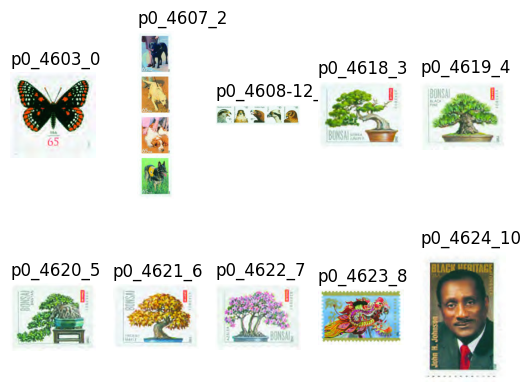

In [11]:
#[Examm] display the frist 10 extracted stamps
from pathlib import Path
img_path = Path(r'./img')
#each elem of the stamp_list is a tuple: (stamp_id, img_file_path)
#img_filepath - '.jpg' == stamp_id == pdf_page_number + stamp_scott_number + sequence_number
stamp_list = sorted([[p.name[:-4],p] for p in img_path.glob('*.jpg')])
display_stamps(stamp_list[:10])


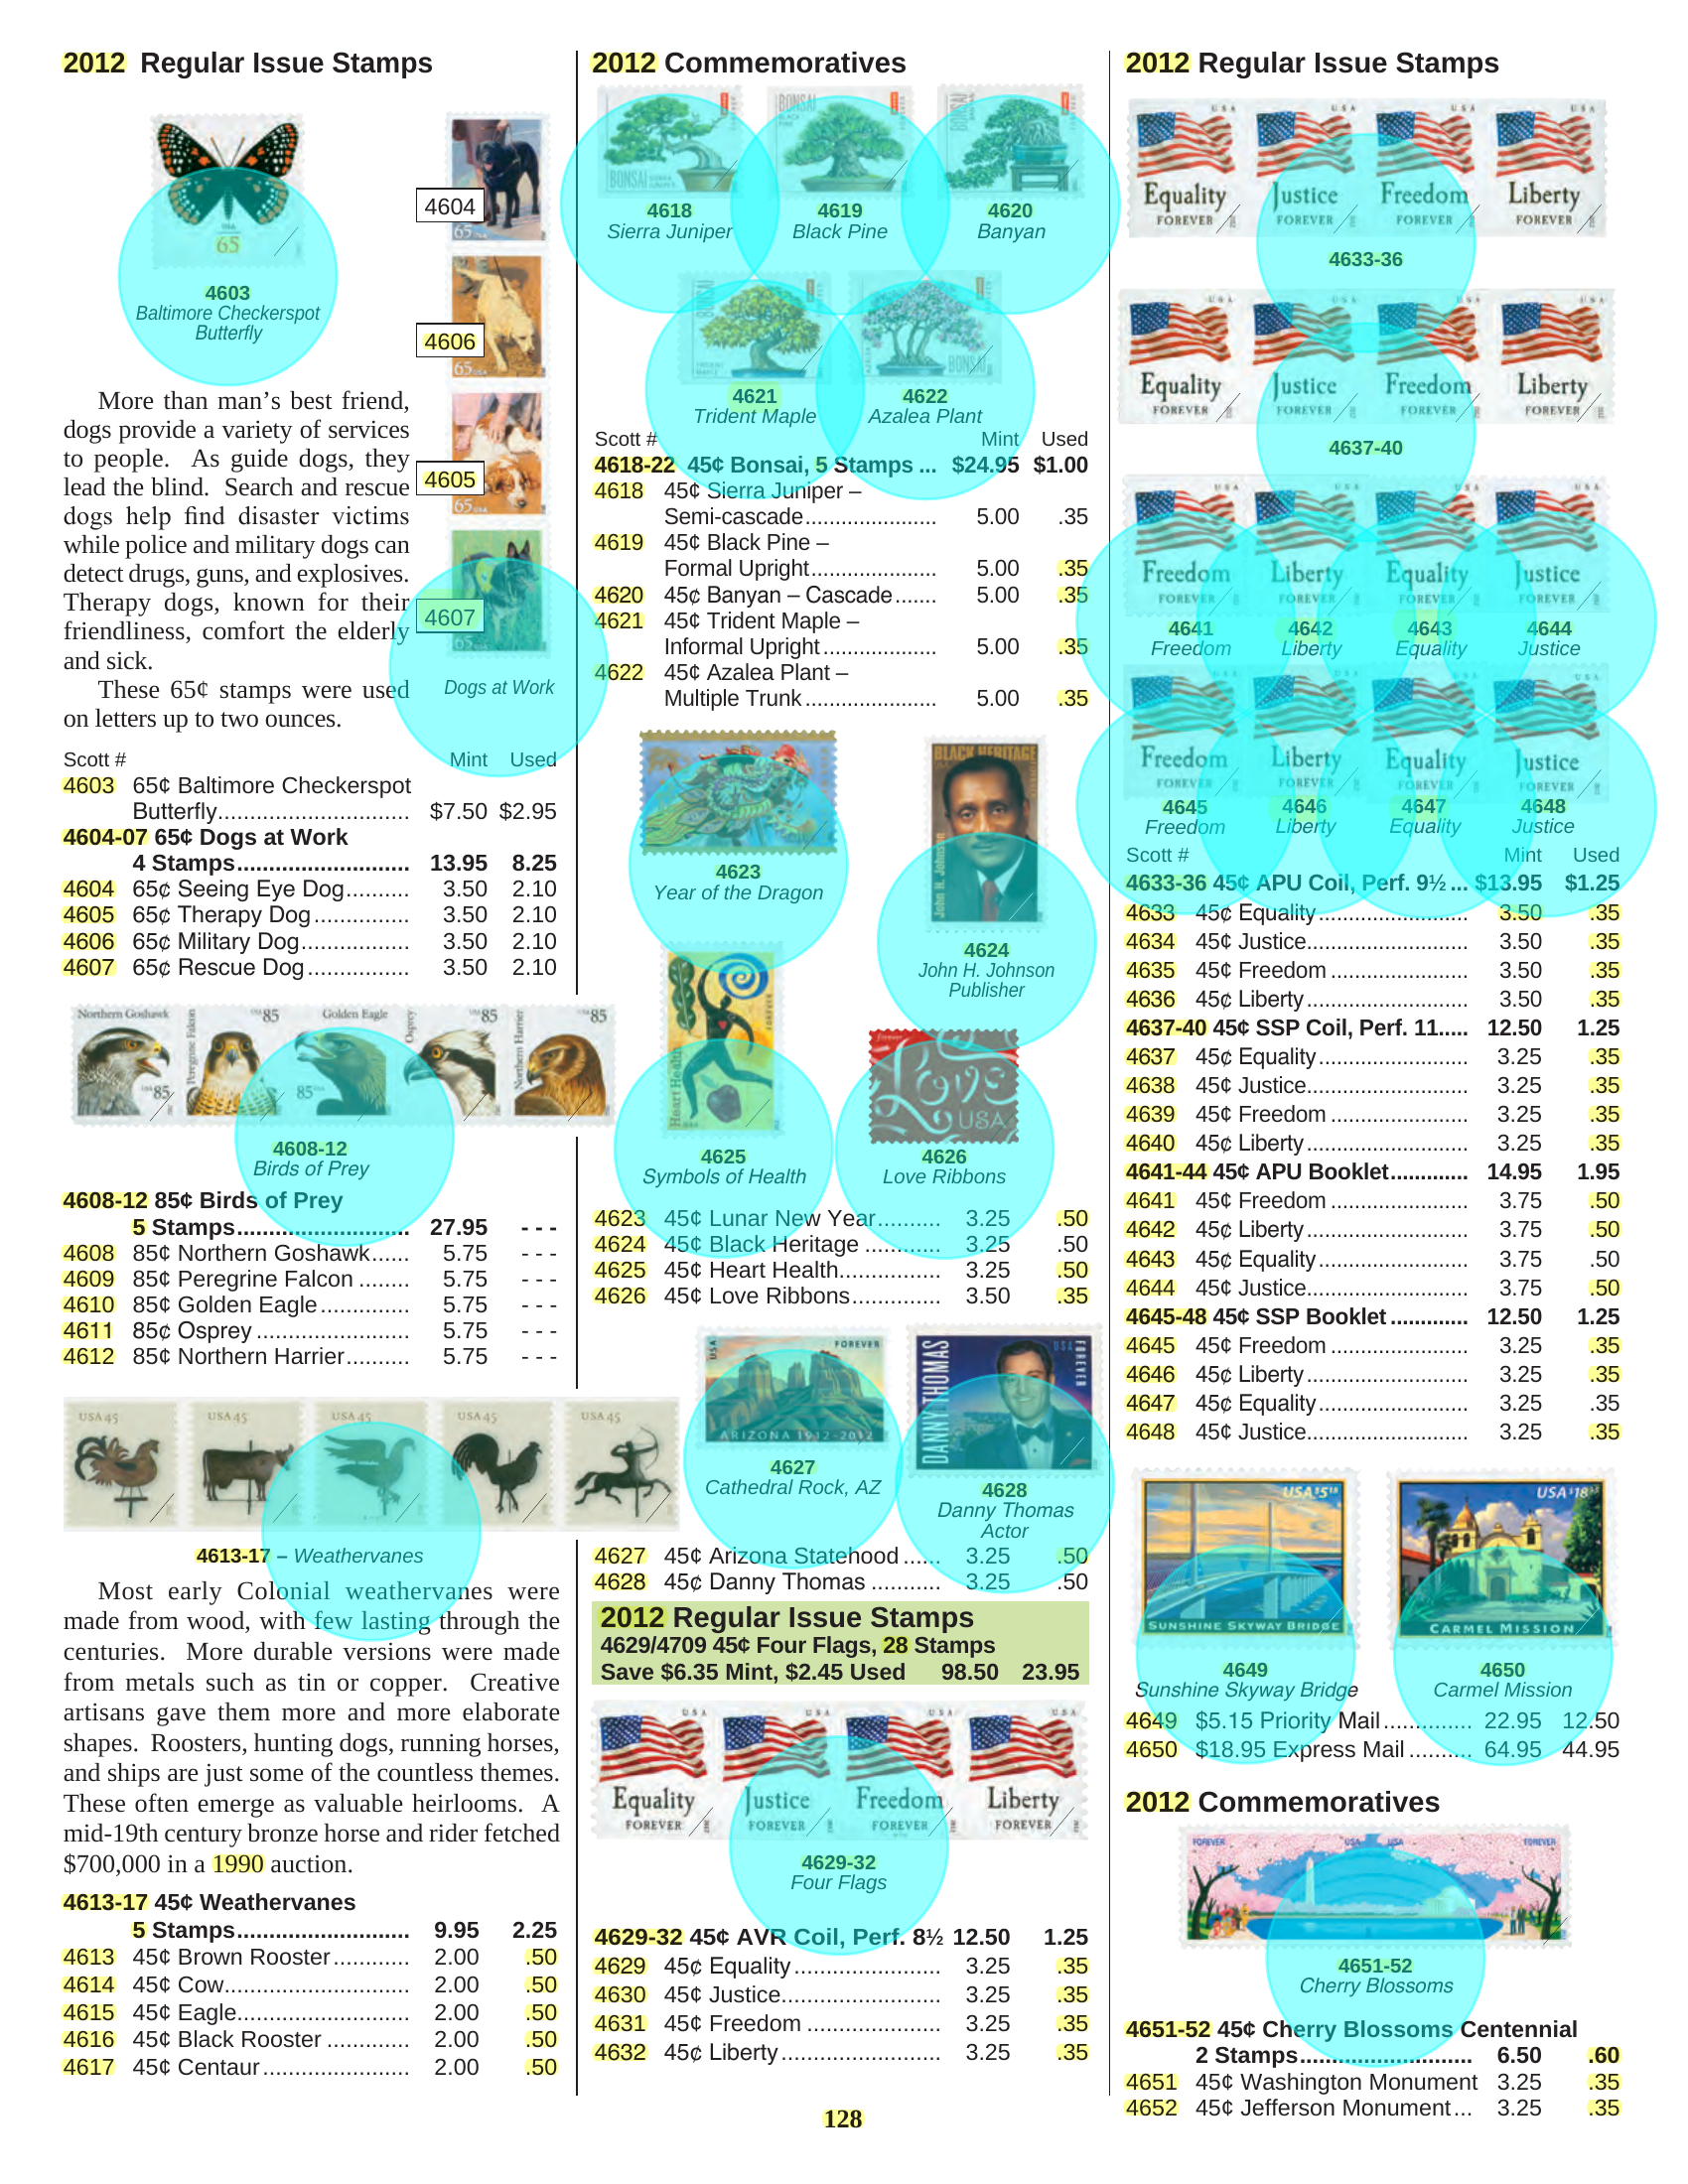

In [12]:
#[Exam] verify if the Scott number has been properly detected in the pdf. Adjust the 'detect_radius' as needed.
#Scott numbers are highlighted in 'yellow'; the detection radii are highlighted in 'cyan'.
import pdf2image
pdf_images = pdf2image.convert_from_path("./debug.pdf")
pdf_images[0]

## Step4: Generate descriptions for stamp images using OpenAI's multi-modal model
**Note:** As of April 2024, the latest multi-modal model for image description is "gpt-4-turbo-2024-04-09."


In [13]:
#search for images in the '/img' folder to create a list of stamps
from pathlib import Path
img_path = Path(r'./img')
stamp_list = sorted([[p.name[:-4],p] for p in img_path.glob('*.jpg')])

#create a csv file to track stamp data, which includes stamp_id, img_file_location, image_description(to be added in the next step)
import pandas as pd
stamp_df = pd.DataFrame(stamp_list, columns=['stamp_id', 'file_location'])
csv_path = Path(r'./stamp.csv')
stamp_df.to_csv(csv_path, index=False)
print(stamp_df.head(5)) #check the first 5 records

       stamp_id         file_location
0     p0_4603_0     img/p0_4603_0.jpg
1     p0_4607_2     img/p0_4607_2.jpg
2  p0_4608-12_1  img/p0_4608-12_1.jpg
3     p0_4618_3     img/p0_4618_3.jpg
4     p0_4619_4     img/p0_4619_4.jpg


In [14]:
#base64(): encode the image for OpenAI multi-modal model processing
import base64
def encode_image(img_path):
    with open(img_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

#requests(): call the OpenAI multi-modal API to get a textual description of the encoded image
import requests
import time
def gen_image_description(img_path, max_retry=5):
    base64_image = encode_image(img_path)
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    payload = {
        #"model": "gpt-4-vision-preview",     #old multi-modal model
        "model": "gpt-4-turbo-2024-04-09",    #latest multi-modal model
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "describe this image in detail"
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        }
                    }
                ]
            }
        ],
        "max_tokens": 1000
    }
    for attempt in range(1, max_retry + 1):
        response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
        if response.status_code == 429: #handle throttling with exponential backoff
            wait = 2 ** attempt
            print(f"Retrying in {wait} seconds...", end='')
            time.sleep(wait)
        else:                           #for non-throttling status, go to next step
            break
    if response.status_code == 200:     #successful API response
        return response.json()
    else:                               #handle API failures
        print(f'\nAPI call failure: {response.status_code}')
        print(f'API call reponse: {response.json()}')
        return None

In [15]:
#retrieve the OpenAI API key from Google Colab Secrets
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
api_key = os.environ['OPENAI_API_KEY']

In [16]:
#process each stamp image to generate a description using the OpenAI multi-modal API
stamp_df = pd.read_csv(csv_path)
stamp_df['image_description'] = None  #create a new column to store image descriptions
#keep track of the API call expenses by recording used tokens
total_input_tokens = 0
total_output_tokens = 0
for idx, row in stamp_df.iloc[:].iterrows():    #set stamp_df.iloc[:10].iterrows() to test the first 10 images
    response = gen_image_description(row['file_location'])
    if ('choices' not in response):
        print(response.json())
        exit()
    #insert the image description into stamp_df
    stamp_df.at[idx, 'image_description'] = response['choices'][0]['message']['content']
    stamp_df.to_csv(csv_path, index=False)
    #accumulate token counts for cost tracking
    total_input_tokens += response['usage']['prompt_tokens']
    total_output_tokens += response['usage']['completion_tokens']
    #display progress and total cost
    print_progress(idx + 1, len(stamp_df))
    total_cost = calculate_token_cost('gpt-4-turbo-2024-04-09', total_input_tokens, total_output_tokens)
    print(f' [multi-modal] total_token:{total_input_tokens}(input),{total_output_tokens}(output) total_cost:${total_cost}', end='')


[██████████████████████████████████████████████████] 100.00%
 [multi-modal] total_token:16190(input),11971(output) total_cost:$0.52

In [17]:
#display the first 5 stamp data
print(stamp_df.head(5))

       stamp_id         file_location  \
0     p0_4603_0     img/p0_4603_0.jpg   
1     p0_4607_2     img/p0_4607_2.jpg   
2  p0_4608-12_1  img/p0_4608-12_1.jpg   
3     p0_4618_3     img/p0_4618_3.jpg   
4     p0_4619_4     img/p0_4619_4.jpg   

                                   image_description  
0  This image features a vibrant and detailed ill...  
1  The image features a vertical series of five d...  
2  This image features a strip of five postage st...  
3  This image features a postage stamp that showc...  
4  The image is of a postage stamp featuring a bo...  


## Step5: Convert stamp image descriptions to OpenAI embeddings and store in ChromaDB

In [18]:
!pip -q install langchain openai tiktoken chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.6/311.6 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.3/299.3 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.0/116.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [19]:
#generate OpenAI embeddings for stamp image descriptions through langchain
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma

stamp_df = pd.read_csv(csv_path)
#create embeddings for stamp image descriptions and store them in a vector database (ChromaDB)
#set stamp_df.iloc[:10].iterrows() to test the first 10 images
docs = [Document(page_content=row['image_description'], metadata={"stamp_id": row['stamp_id'], "file_location": row['file_location']}) for idx, row in stamp_df.iloc[:].iterrows()]
doc_ids = [str(i) for i in range(len(docs))]
#initialize ChromaDB to use as the vector database
vectordb = Chroma.from_documents(documents=docs,
                                 embedding=OpenAIEmbeddings(),                 #using OpenAI Embedding
                                 collection_metadata={"hnsw:space": "cosine"}, #set distance_function to cosine_similarity, https://docs.trychroma.com/usage-guide#changing-the-distance-function
                                 persist_directory='chroma_db',
                                 ids=doc_ids)
#persist the generated embeddings to ChromaDB
vectordb.persist()
#output the count of records stored in ChromaDB
print(f'records in chromadb: {vectordb._collection.count()}')


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


records in chromadb: 60


## Step6: Perform test queries using text or images

1. **To prepare training images for testing:** copy several images from the '/img' folder to the '/test' folder.
2. **To prepare unseen images for testing:** download some images from the internet and save them to the '/test' folder.


In [20]:
#query_vectordb_with_text(): query the vector database with a text input and return similar items
def query_vectordb_with_text(vectordb, query_text, max_result=5):
    #perform a similarity search in the vector database for the top results
    docs = vectordb.similarity_search_with_score(query_text, k=max_result)    #by default, return the top 5 most similar stamps
    #extract relevant information from the results: [(stamp_id, img_file_location, similarity_distance), (), (), ...]
    stamp_list = [(doc[0].metadata['stamp_id'], doc[0].metadata['file_location'], f'{doc[1]:.3f}') for doc in docs]
    #image_description_list = [doc[0].page_content for doc in docs]
    return stamp_list

#query_vectordb_with_image():  query the vector database with an image input and return similar items
def query_vectordb_with_image(vectordb, query_image_path, max_result=5):
    #generate a description of the image using an multi-modal model
    response = gen_image_description(query_image_path)
    image_desciption = response['choices'][0]['message']['content']
    #print(image_desciption)
    #cost tracking
    total_input_tokens = response['usage']['prompt_tokens']
    total_output_tokens = response['usage']['completion_tokens']
    total_cost = calculate_token_cost('gpt-4-turbo-2024-04-09', total_input_tokens, total_output_tokens)
    print(f'token:{total_input_tokens + total_output_tokens} cost:${total_cost}')
    #query the vector database using the generated image description
    stamp_list = query_vectordb_with_text(vectordb, image_desciption, max_result)
    return stamp_list

#testing_text_query(): test querying a vector database using textual input
def testing_text_query(vectordb, text):
    print(f'[query text]{text}')
    stamp_list = query_vectordb_with_text(vectordb, text)
    print(f'[query result]{stamp_list}')
    display_stamps(stamp_list)

#testing_img_query(): test querying a vector database using an image
def testing_img_query(vectordb, img_path):
    print(f'[query img]{img_path}')
    display_stamps([('test img', img_path)])
    stamp_list = query_vectordb_with_image(vectordb, img_path)
    print(f'[query result]{stamp_list}')
    display_stamps(stamp_list)



[query text]flag
[query result][('p0_4645_21', 'img/p0_4645_21.jpg', '0.191'), ('p0_4648_24', 'img/p0_4648_24.jpg', '0.210'), ('p0_4646_22', 'img/p0_4646_22.jpg', '0.211'), ('p0_4642_18', 'img/p0_4642_18.jpg', '0.212'), ('p0_4641_17', 'img/p0_4641_17.jpg', '0.212')]


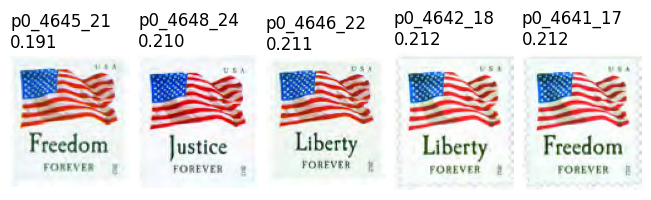

[query text]tree
[query result][('p0_4620_5', 'img/p0_4620_5.jpg', '0.181'), ('p0_4622_7', 'img/p0_4622_7.jpg', '0.195'), ('p0_4618_3', 'img/p0_4618_3.jpg', '0.209'), ('p0_4621_6', 'img/p0_4621_6.jpg', '0.213'), ('p0_4619_4', 'img/p0_4619_4.jpg', '0.217')]


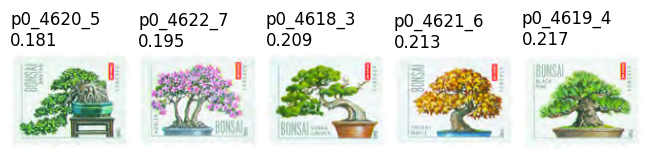

In [21]:
#[Exam]chromaDB vector search1: text query
vectordb = Chroma(persist_directory='chroma_db',
                  embedding_function=OpenAIEmbeddings())
testing_text_query(vectordb, "flag")
testing_text_query(vectordb, "tree")

[query img]./test/test1_1.png


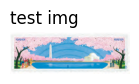

token:561 cost:$0.01
[query result][('p0_4651-52_27', 'img/p0_4651-52_27.jpg', '0.023'), ('p2_4712-15_58', 'img/p2_4712-15_58.jpg', '0.103'), ('p0_4633-36_15', 'img/p0_4633-36_15.jpg', '0.113'), ('p0_4621_6', 'img/p0_4621_6.jpg', '0.114'), ('p1_4665_36', 'img/p1_4665_36.jpg', '0.115')]


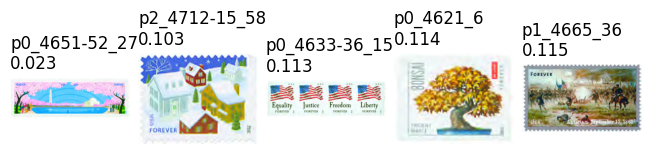

[query img]./test/test1_2.png


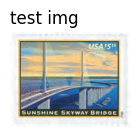

token:420 cost:$0.01
[query result][('p0_4649_25', 'img/p0_4649_25.jpg', '0.028'), ('p2_4717-20_55', 'img/p2_4717-20_55.jpg', '0.092'), ('p0_4650_26', 'img/p0_4650_26.jpg', '0.110'), ('p0_4641_17', 'img/p0_4641_17.jpg', '0.113'), ('p0_4651-52_27', 'img/p0_4651-52_27.jpg', '0.114')]


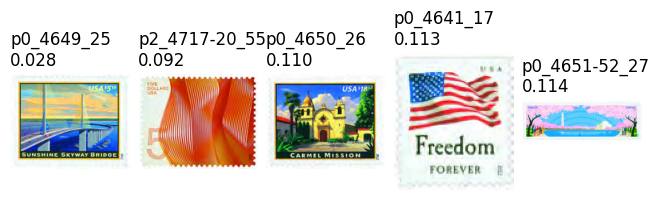

[query img]./test/test1_3.png


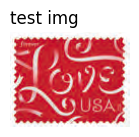

token:368 cost:$0.01
[query result][('p0_4626_9', 'img/p0_4626_9.jpg', '0.031'), ('p0_4641_17', 'img/p0_4641_17.jpg', '0.072'), ('p2_4726_57', 'img/p2_4726_57.jpg', '0.073'), ('p2_4706-09_51', 'img/p2_4706-09_51.jpg', '0.078'), ('p0_4642_18', 'img/p0_4642_18.jpg', '0.083')]


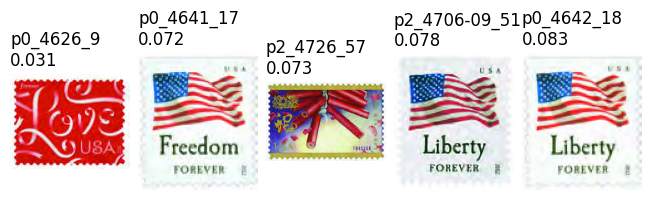

[query img]./test/test1_4.png


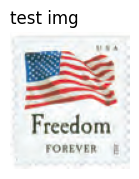

token:463 cost:$0.01
[query result][('p0_4641_17', 'img/p0_4641_17.jpg', '0.018'), ('p0_4642_18', 'img/p0_4642_18.jpg', '0.028'), ('p2_4706-09_51', 'img/p2_4706-09_51.jpg', '0.028'), ('p0_4646_22', 'img/p0_4646_22.jpg', '0.033'), ('p1_4673-76_42', 'img/p1_4673-76_42.jpg', '0.033')]


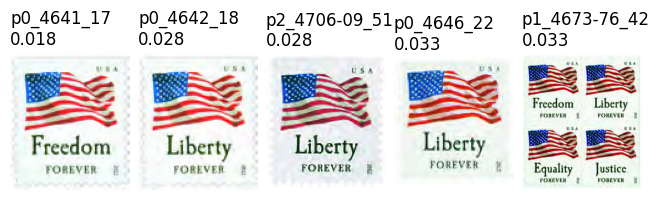

[query img]./test/test1_5.png


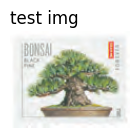

token:433 cost:$0.01
[query result][('p0_4618_3', 'img/p0_4618_3.jpg', '0.014'), ('p0_4619_4', 'img/p0_4619_4.jpg', '0.020'), ('p0_4621_6', 'img/p0_4621_6.jpg', '0.020'), ('p0_4622_7', 'img/p0_4622_7.jpg', '0.077'), ('p0_4620_5', 'img/p0_4620_5.jpg', '0.089')]


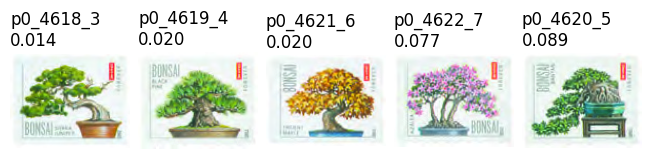

In [22]:
#[Exam]chromaDB vector search2: Image query with training images
testing_img_query(vectordb, "./test/test1_1.png")
testing_img_query(vectordb, "./test/test1_2.png")
testing_img_query(vectordb, "./test/test1_3.png")
testing_img_query(vectordb, "./test/test1_4.png")
testing_img_query(vectordb, "./test/test1_5.png")

[query img]./test/test2_1.png


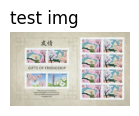

token:525 cost:$0.01
[query result][('p0_4651-52_27', 'img/p0_4651-52_27.jpg', '0.092'), ('p0_4621_6', 'img/p0_4621_6.jpg', '0.094'), ('p0_4619_4', 'img/p0_4619_4.jpg', '0.101'), ('p0_4618_3', 'img/p0_4618_3.jpg', '0.102'), ('p2_4726_57', 'img/p2_4726_57.jpg', '0.112')]


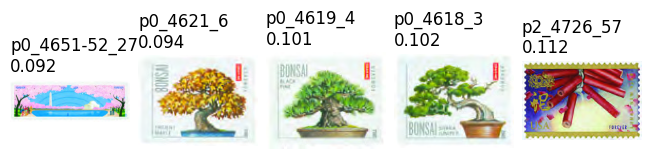

[query img]./test/test2_2.png


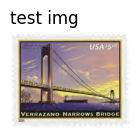

token:483 cost:$0.01
[query result][('p0_4649_25', 'img/p0_4649_25.jpg', '0.075'), ('p2_4703_46', 'img/p2_4703_46.jpg', '0.129'), ('p0_4650_26', 'img/p0_4650_26.jpg', '0.129'), ('p0_4651-52_27', 'img/p0_4651-52_27.jpg', '0.130'), ('p2_4717-20_55', 'img/p2_4717-20_55.jpg', '0.131')]


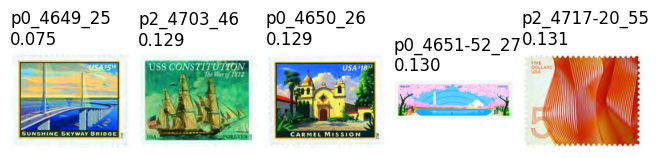

[query img]./test/test2_3.png


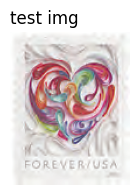

token:479 cost:$0.01
[query result][('p0_4626_9', 'img/p0_4626_9.jpg', '0.041'), ('p2_4726_57', 'img/p2_4726_57.jpg', '0.053'), ('p0_4641_17', 'img/p0_4641_17.jpg', '0.058'), ('p2_4706-09_52', 'img/p2_4706-09_52.jpg', '0.058'), ('p0_4647_23', 'img/p0_4647_23.jpg', '0.062')]


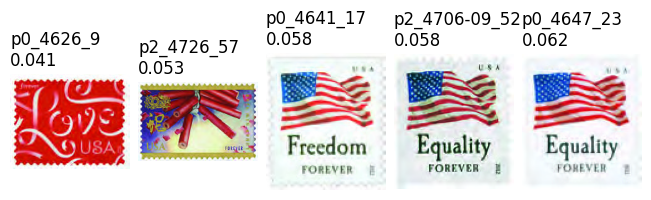

[query img]./test/test2_4.png


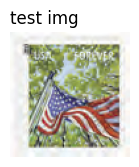

token:391 cost:$0.01
[query result][('p2_4706-09_51', 'img/p2_4706-09_51.jpg', '0.039'), ('p0_4642_18', 'img/p0_4642_18.jpg', '0.040'), ('p0_4648_24', 'img/p0_4648_24.jpg', '0.041'), ('p0_4641_17', 'img/p0_4641_17.jpg', '0.042'), ('p0_4633-36_15', 'img/p0_4633-36_15.jpg', '0.047')]


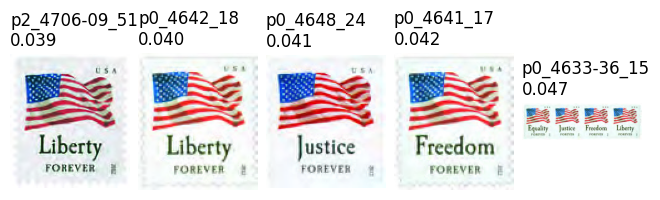

[query img]./test/test2_5.png


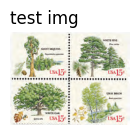

token:574 cost:$0.01
[query result][('p0_4619_4', 'img/p0_4619_4.jpg', '0.093'), ('p0_4621_6', 'img/p0_4621_6.jpg', '0.101'), ('p0_4618_3', 'img/p0_4618_3.jpg', '0.107'), ('p0_4608-12_1', 'img/p0_4608-12_1.jpg', '0.120'), ('p2_4712-15_58', 'img/p2_4712-15_58.jpg', '0.128')]


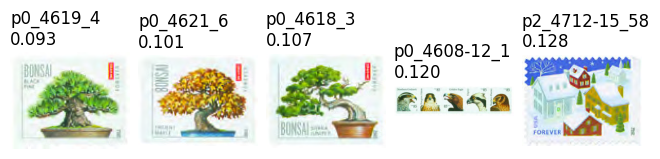

In [23]:
#[Exam]chromaDB vector search3: image query with unseen images
testing_img_query(vectordb, "./test/test2_1.png")
testing_img_query(vectordb, "./test/test2_2.png")
testing_img_query(vectordb, "./test/test2_3.png")
testing_img_query(vectordb, "./test/test2_4.png")
testing_img_query(vectordb, "./test/test2_5.png")

## Step7: Backup generated artifacts

1. Artifacts for Part 2:
   - **2012.pdf**: The small demonstration dataset containing stamps issued in 2012.

2. Artifacts for Part 3:
   - **stamp.csv**: The csv file tracking stamp data, including stamp_id, img_file_location, and image_description
   - **/img**: The folder storing all stamp images.
   - **/test**: The folder storing test images.

3. Reference artifacts:
   - **debug.pdf**: The enhanced version of 2012.pdf that highlights the Scott number and detection radius, aiding in the verification of correct Scott number detection.
   - **/chroma_db**: The vector database storing stamp image descriptions.





In [24]:
#pack generated artifacts into a zip file
!zip -r data_part1.zip 2012.pdf debug.pdf stamp.csv img test chroma_db  > /dev/null

In [25]:
#download the zip file (~6M) for future use
from google.colab import files
files.download('data_part1.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>